## Lesson 22:
### Exercise 1: Galaxies vs Quasars with neural networks

In [167]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
%config InlineBackend.figure_format='retina'

c = sns.color_palette('Paired', 7)
plt.rcParams['figure.figsize'] = (8, 5)

#------------------- Function to read the data -------------------
def Dataframe(namefile):                                        #-
    df = pd.read_csv(namefile, sep=',', skipinitialspace=True)  #-
    return df                                                   #-
#-----------------------------------------------------------------

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)


In [168]:
data = Dataframe("galaxyquasar.csv")
data = data.dropna()
num_rows = len(data.index)

In [169]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])
classes = np.where(data['class']=='QSO', 1, 0) # 1 is QSO, 0 is GALAXY

# add those as dataframe columns
data['u-g'] = u_g
data['g-r'] = g_r
data['r-i'] = r_i
data['i-z'] = i_z
data['class_num'] = classes

X = data.loc[:, ['u-g', 'g-r', 'r-i', 'i-z']].to_numpy()
y = data.loc[:, ['class_num']].to_numpy()

### Data normalization + training/test split
We can split the entire dataset into a **training set** and a **test set** using the Scikit Learn *train_test_split* function. $30\%$ of the data goes into the test set. But first we normalize our dataset so that it has zero mean and unit variance in every dimension. This can also be done using te usual *StandardScaler* module of *Scikit-learn*

In [170]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Normalization

In [171]:
normalizer = Normalization(axis=-1)
normalizer.adapt(X)
X_scaled = np.array(normalizer(X))
print(X_scaled)

[[-1.6009315  -2.1856418  -0.5065469  -0.6597548 ]
 [ 0.8389082   1.1876656   0.41731626  0.47661254]
 [ 0.7716434   0.50527114 -0.04953469 -0.14751536]
 ...
 [ 0.01402752 -0.6316651  -0.43134817 -0.1131583 ]
 [-0.06667943  0.08235198  0.26992127 -0.17028071]
 [-0.47648627 -0.89827895 -0.71412855 -0.5216425 ]]


In [172]:
# 30% test set, 70% training set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state=42)
print('Training dataset: ')
print(X_train)
print('\nShape of train:')
print(X_train.shape)
print('\nTest dataset: \n')
print(X_test)
print('\nShape of test:')
print(X_test.shape)

Training dataset: 
[[-0.25857967 -0.42241818 -0.07498585 -0.15694074]
 [ 0.04050914  0.7225612   0.5851738   0.2751449 ]
 [-0.45488775  0.2466035   0.3954218  -0.12733439]
 ...
 [-0.11176035 -0.532759   -0.39111596 -0.15777688]
 [ 0.2232835   0.04969563 -0.26626214 -0.2842215 ]
 [-2.1775286  -1.6597466  -0.00537629 -0.62349755]]

Shape of train:
(35000, 4)

Test dataset: 

[[-0.25038645  0.45543054  0.17860198  0.25781438]
 [ 0.4563877   0.10218507  0.18474531  0.20890112]
 [-1.8718194  -1.3098927  -0.75154316 -0.8665433 ]
 ...
 [ 1.0172385   0.6242687   0.23158284  0.33386356]
 [ 1.0394042   0.80974203  0.40521422  0.42728132]
 [ 0.85955596  0.77159435  0.6788487   0.54962134]]

Shape of test:
(15000, 4)


In [173]:
def pred_visualization(X_test, y_test, y_p):
    fig = plt.figure()
    
    galaxies = (y_p == 0)

    plt.scatter(X_test[galaxies][:, 0], X_test[galaxies][:, 1], 
            s=10, edgecolors='none', alpha=0.5, 
            label='Galaxy', color=c[3])

    plt.scatter(X_test[~galaxies][:, 0], X_test[~galaxies][:, 1], 
            s=10, edgecolors='none', alpha=0.5, 
            label='QSO', color=c[6])
    
    plt.xlim(-4, 3)
    plt.ylim(-5, 5)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.legend(loc='best', fontsize=10, frameon=True)
    plt.grid(True, ls='--', alpha=0.2)

In [179]:
tf.random.set_seed(42)

# Create the network
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001
#----------------------------------------------------------------------------
""" Adapting learning rate: not producing better accuracies.

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
"""
#----------------------------------------------------------------------------
# Compile
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
             metrics=['accuracy'])
# Fit
history = model.fit(X_train, y_train,
                   epochs=25)

Epoch 1/25
1094/1094 [==============================] - 1s 771us/step - loss: 0.1603 - accuracy: 0.9661
Epoch 2/25
1094/1094 [==============================] - 1s 746us/step - loss: 0.0814 - accuracy: 0.9818
Epoch 3/25
1094/1094 [==============================] - 1s 762us/step - loss: 0.0778 - accuracy: 0.9825
Epoch 4/25
1094/1094 [==============================] - 1s 767us/step - loss: 0.0765 - accuracy: 0.9830
Epoch 5/25
1094/1094 [==============================] - 1s 799us/step - loss: 0.0762 - accuracy: 0.9824
Epoch 6/25
1094/1094 [==============================] - 1s 775us/step - loss: 0.0750 - accuracy: 0.9827
Epoch 7/25
1094/1094 [==============================] - 1s 767us/step - loss: 0.0742 - accuracy: 0.9826
Epoch 8/25
1094/1094 [==============================] - 1s 774us/step - loss: 0.0732 - accuracy: 0.9828
Epoch 9/25
1094/1094 [==============================] - 1s 776us/step - loss: 0.0709 - accuracy: 0.9833
Epoch 10/25
1094/1094 [==============================] - 1s 770u

In [180]:
y_pred = model.predict(X_test)

# We approximate every value below 0.5 to 0 and above 0.5 to 1
y_pred_binary = np.array(tf.round(y_pred)).ravel()

469/469 [==============================] - 0s 510us/step


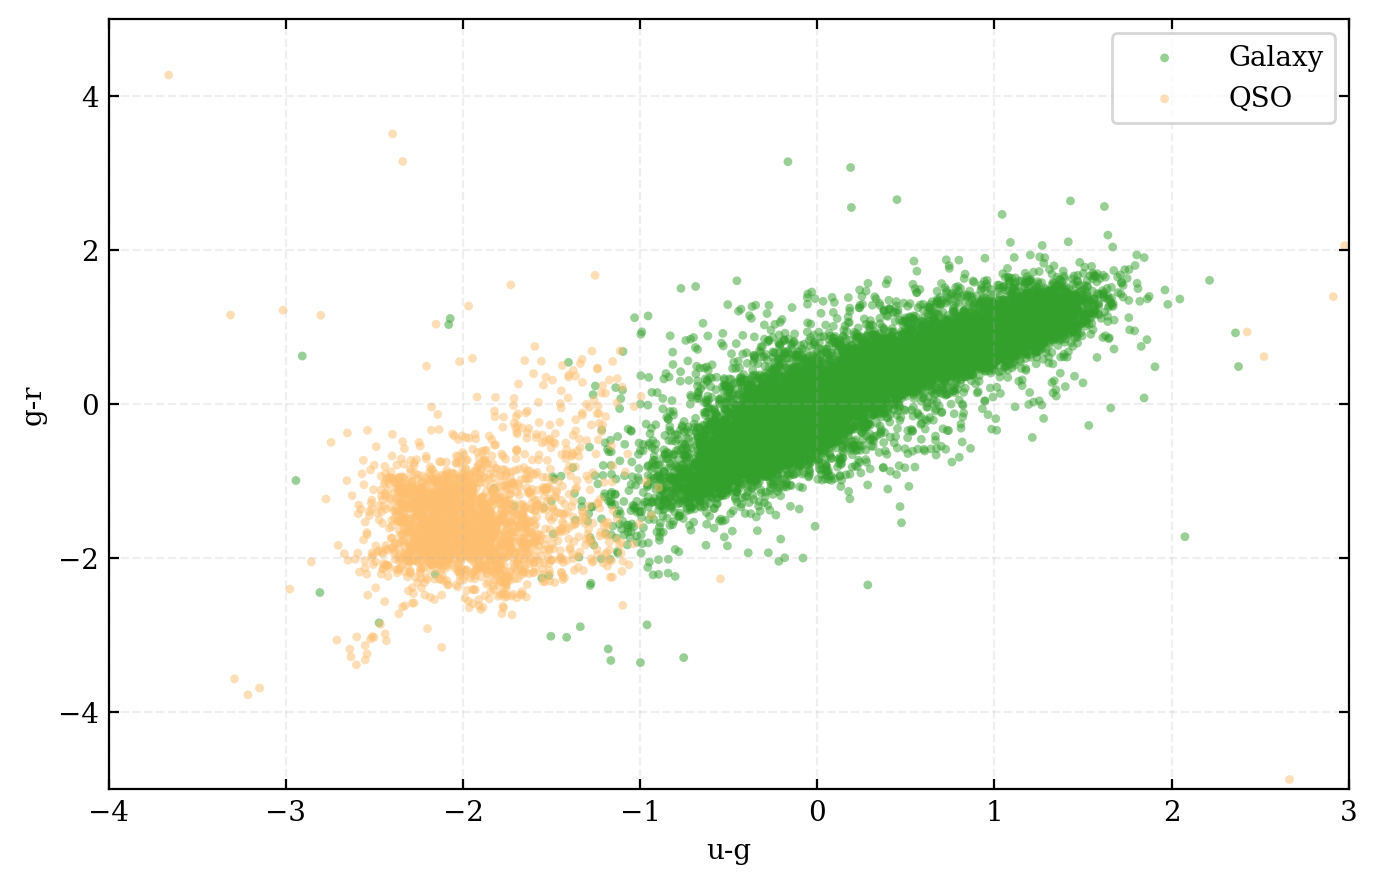

In [181]:
pred_visualization(X_test, y_test, y_pred_binary)

Now we evaluate the model on the test set

In [182]:
loss, accuracy = model.evaluate(X_test, y_test)

469/469 [==============================] - 0s 587us/step - loss: 0.0732 - accuracy: 0.9837


In [183]:
print('The accuracy of our Neural Network Classifier is', round(accuracy*100, 2), '%')

The accuracy of our Neural Network Classifier is 98.37 %


> **That's 2% better with respect to the Random Forest Classifier we used in the previous exercise**

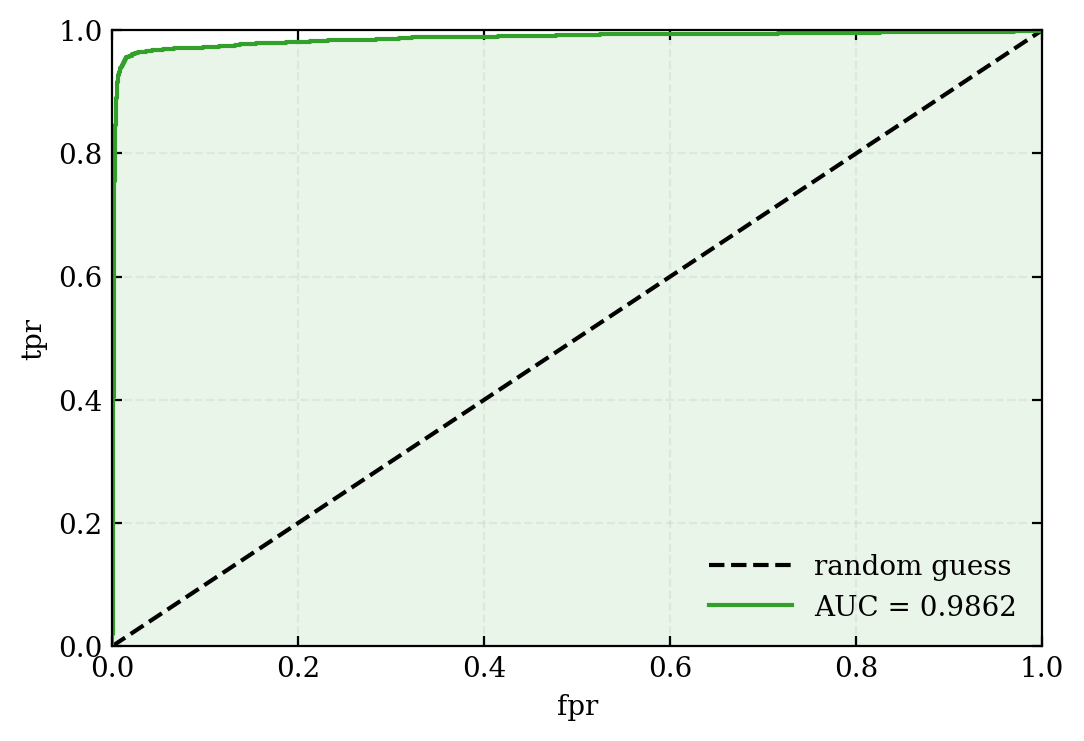

In [184]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot([0,1], [0,1], '--k', label='random guess')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_tf = auc(fpr, tpr)

ax.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_tf), color=c[3])
ax.fill_between(fpr, tpr, color=c[3], alpha=0.1)
ax.set_xlabel('fpr');
ax.set_ylabel('tpr');
ax.legend(loc='lower right', frameon=False);
ax.grid(True, ls='--', alpha=0.2)

plt.show()

---
#### Let's try some PCA dimensionality reduction before performing classification...

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
pca.fit(X_scaled)

proj = pca.transform(X_scaled) # projection of the data: This reconstructs the signal using the two components ICA computed
# comp = ica.components_

In [162]:
pca_xtrain, pca_xtest, pca_ytrain, pca_ytest = train_test_split(proj, y, test_size = 0.3, random_state=42)

In [163]:
tf.random.set_seed(42)

# Create the network
model_pca = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=pca_xtrain.shape[1]),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001
#----------------------------------------------------------------------------
""" Adapting learning rate: not producing better accuracies.

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
"""
#----------------------------------------------------------------------------
# Compile
model_pca.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
             metrics=['accuracy'])
# Fit
history = model_pca.fit(pca_xtrain, pca_ytrain,
                   epochs=25)

Epoch 1/25
1094/1094 [==============================] - 1s 791us/step - loss: 0.1864 - accuracy: 0.9502
Epoch 2/25
1094/1094 [==============================] - 1s 761us/step - loss: 0.1313 - accuracy: 0.9685
Epoch 3/25
1094/1094 [==============================] - 1s 761us/step - loss: 0.1293 - accuracy: 0.9695
Epoch 4/25
1094/1094 [==============================] - 1s 783us/step - loss: 0.1278 - accuracy: 0.9695
Epoch 5/25
1094/1094 [==============================] - 1s 782us/step - loss: 0.1258 - accuracy: 0.9700
Epoch 6/25
1094/1094 [==============================] - 1s 784us/step - loss: 0.1233 - accuracy: 0.9702
Epoch 7/25
1094/1094 [==============================] - 1s 793us/step - loss: 0.1221 - accuracy: 0.9702
Epoch 8/25
1094/1094 [==============================] - 1s 808us/step - loss: 0.1204 - accuracy: 0.9703
Epoch 9/25
1094/1094 [==============================] - 1s 788us/step - loss: 0.1190 - accuracy: 0.9702
Epoch 10/25
1094/1094 [==============================] - 1s 775u

In [164]:
pca_y_pred = model_pca.predict(pca_xtest)

# We approximate every value below 0.5 to 0 and above 0.5 to 1
pca_y_pred_binary = np.array(tf.round(pca_y_pred)).ravel()

469/469 [==============================] - 0s 468us/step


In [165]:
loss_pca, accuracy_pca = model_pca.evaluate(pca_xtest, pca_ytest)

469/469 [==============================] - 0s 565us/step - loss: 0.1093 - accuracy: 0.9735


In [166]:
print('The accuracy of the Neural Network Classifier, with PCA applied first, is', round(accuracy_pca*100, 2), '%')

The accuracy of the Neural Network Classifier, with PCA applied first, is 97.35 %


The accuracy was **not** improved by applying PCA first.